# PokeGAN


In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [2]:
# Convert PNG to JPG
import os
from utils import convert_to_png

if not os.path.exists(os.path.join('data', 'pokemon_jpg')):
    convert_to_png(os.path.join('tmp', 'pokemon'), os.path.join('data', 'pokemon_jpg'))

In [3]:
from preprocessing import get_dataloader

In [4]:
batch_size = 64
img_size = 64

In [5]:
poke_loader = get_dataloader(batch_size, img_size, data_dir='data')

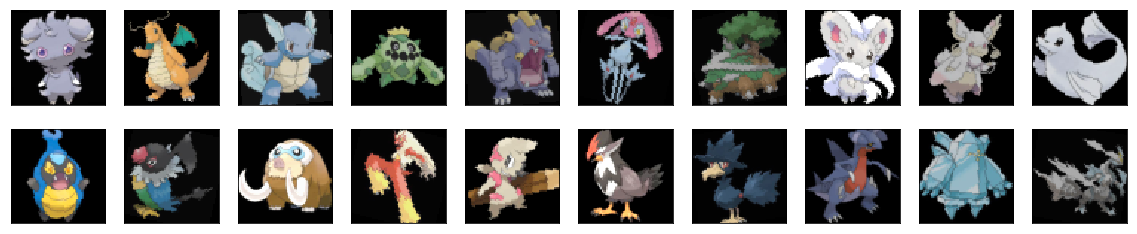

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(poke_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [7]:
# Model hyperparameters
z_size = 100
latent_feature_size = 4

d_conv_dim = 32
d_ksize = 3
d_stride = 2
g_conv_dim = 32
g_ksize = 5
g_stride = 2
use_dropout = True
norm_block = nn.BatchNorm2d
# norm_block = nn.InstanceNorm2d

In [8]:
from models import Discriminator, Generator
from optim import get_noise, normal_initialization

In [9]:
# Discriminator net
d_depth = int(np.log2(img_size / latent_feature_size))
d_channels = [3] + [2 ** idx * d_conv_dim for idx in range(d_depth)]
D = Discriminator(d_channels, img_size, d_ksize, d_stride,
                  normalization_block=norm_block, use_dropout=use_dropout,
                  init_weights=normal_initialization)

# Generator net
g_depth = d_depth + int(np.log2(d_conv_dim / g_conv_dim))
g_channels = [2 ** (g_depth - 1 - idx) * g_conv_dim for idx in range(g_depth)] + [3]
G = Generator(z_size, g_channels, img_size, g_ksize, g_stride,
              normalization_block=norm_block, use_dropout=use_dropout,
              init_weights=normal_initialization)

print(D)
print()
print(G)

Discriminator(
  (downblock): Sequential(
    (layer_1): Sequential(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (activation): LeakyReLU(negative_slope=0.2)
      (dropout): Dropout(p=0.3)
    )
    (layer_2): Sequential(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.2)
      (dropout): Dropout(p=0.3)
    )
    (layer_3): Sequential(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.2)
      (dropout): Dropout(p=0.3)
    )
    (layer_4): Sequential(
      (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): BatchNorm2

In [10]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [11]:
# move models to GPU
if train_on_gpu:
    D.cuda()
    G.cuda()
from torchsummary import summary
summary(D, (3, img_size, img_size))
# summary(G, (1, z_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
         LeakyReLU-2           [-1, 64, 32, 32]               0
           Dropout-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]          73,728
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
           Dropout-7          [-1, 128, 16, 16]               0
            Conv2d-8            [-1, 256, 8, 8]         294,912
       BatchNorm2d-9            [-1, 256, 8, 8]             512
        LeakyReLU-10            [-1, 256, 8, 8]               0
          Dropout-11            [-1, 256, 8, 8]               0
           Conv2d-12            [-1, 512, 4, 4]       1,179,648
      BatchNorm2d-13            [-1, 512, 4, 4]           1,024
        LeakyReLU-14            [-1, 51

In [12]:
from torch.utils.tensorboard import SummaryWriter
logger = SummaryWriter("logs")

In [13]:
import torch.optim as optim

# params
criterion = nn.BCEWithLogitsLoss()
cycles = [dict(lr=1e-3, nb_epochs=200),
          dict(lr=5e-4, nb_epochs=800),
          dict(lr=2e-4, nb_epochs=4000)]
beta1 = 0.5
beta2 = 0.999

In [14]:
from train import train_GAN

In [15]:
!rm -r logs/*

In [16]:
# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = get_noise((sample_size, z_size))

# Train with specified cycles
tot_epochs = 0
for cycle_idx, cycle_settings in enumerate(cycles):
    # Create optimizers for the discriminator D and generator G
    d_optimizer = optim.Adam(D.parameters(), cycle_settings.get('lr'), [beta1, beta2])
    g_optimizer = optim.Adam(G.parameters(), cycle_settings.get('lr'), [beta1, beta2])
    train_GAN(D, d_optimizer, G, g_optimizer, poke_loader, fixed_z,
              criterion, cycle_settings.get('nb_epochs'), train_on_gpu,
              logger, log_every=10, sample_print_freq=100, starting_epoch=tot_epochs)
    tot_epochs += cycle_settings.get('nb_epochs')

Epoch [   10/  200] | d_loss: 0.8383 | g_loss: 7.3777
Epoch [   20/  200] | d_loss: 2.3475 | g_loss: 7.3199
Epoch [   30/  200] | d_loss: 2.0058 | g_loss: 5.4879


KeyboardInterrupt: 

In [ ]:
logger.close()

In [ ]:
import matplotlib.pyplot as plt
from utils import print_samples

In [ ]:
# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = get_noise((sample_size, z_size))
G.eval() # for generating samples
samples_z = G(fixed_z)
print_samples(samples_z, title="Final epoch", img_size=img_size)
plt.show()

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((img_size,img_size,3)))

In [ ]:
_ = view_samples(-1, samples)